In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import urllib
import itertools
import numpy as np
import pandas as Pd
import seaborn as sns
import random, os, glob
from imutils import paths
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from urllib.request import urlopen

# libraries that used to turn off warnings.
import warnings
warnings. filterwarnings('ignore')

# libraries to be used for model evaluation
from sklearn.metrics import confusion_matrix, classification_report

# libraries to be used for the model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint ,EarlyStopping
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, SpatialDropout2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img

In [ ]:
# loading dataset
dir_path = "/content/drive/MyDrive/data3a/training"

validation_path = "/content/drive/MyDrive/data3a/validation"

In [ ]:
batch_size = 64
img_height = 224
img_width = 224

In [ ]:
train_data_gen = ImageDataGenerator(horizontal_flip=True,
                           vertical_flip=True,
                           validation_split=0.2,
                           rescale=1./255,
                           shear_range=0.1,
                           zoom_range=0.1,
                           width_shift_range=0.1,
                           height_shift_range=0.1)

# Use flow_from_directory for the training dataset
train_ds = train_data_gen.flow_from_directory(
    dir_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    seed=123,
    shuffle=True
)
valid_ds = train_data_gen.flow_from_directory(
    dir_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    seed=123,
    shuffle=True
)

Found 1108 images belonging to 3 classes.
Found 275 images belonging to 3 classes.


In [ ]:
test_data_gen = ImageDataGenerator(rescale=1./255,)
test_ds = test_data_gen.flow_from_directory(
    validation_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 248 images belonging to 3 classes.


In [ ]:
cl=test_ds.class_indices
print(cl)

{'01-minor': 0, '02-moderate': 1, '03-severe': 2}


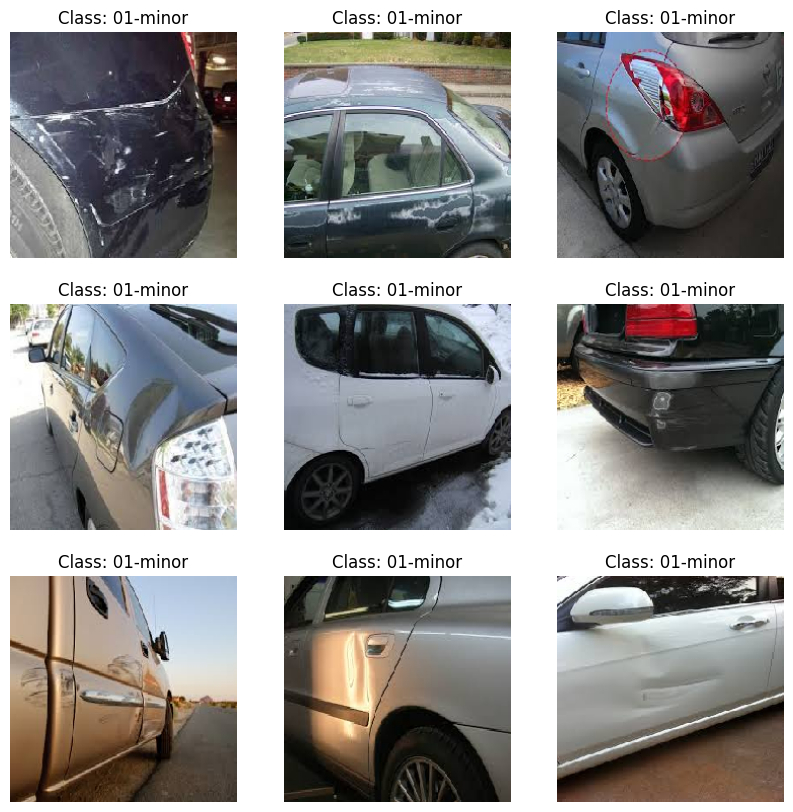

In [ ]:
def plot_images_from_dataset(dataset, num_images=9):

    images, labels = next(iter(dataset))

    plt.figure(figsize=(10, 10))
    for i in range(min(num_images, len(images))):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        label_index = labels[i].argmax()  # Assumes one-hot encoding
        class_name = next(key for key, value in cl.items() if value == label_index)
        plt.title(f"Class: {class_name}")
        plt.axis("off")
    plt.show()
plot_images_from_dataset(test_ds)

In [ ]:
def plot_images_from_dataset2(dataset, num_images=9):
    # Veri setinden ilk batch'i alın
    images, labels = next(iter(dataset))

    # Tüm sınıflardan örnekler almak için sınıf başına örnekleri bir araya getirin
    class_dict = {value: key for key, value in cl.items()}  # Sınıf etiketleri ile tersine çevrilmiş bir sözlük
    class_images = {key: [] for key in class_dict.keys()}  # Sınıf başına boş liste

    for image, label in zip(images, labels):
        label_index = label.argmax()
        class_images[label_index].append(image)

    # Görselleştirme
    plt.figure(figsize=(10, 10))
    count = 0
    for class_index, image_list in class_images.items():
        for img in image_list[:num_images // len(class_dict)]:  # Her sınıftan eşit sayıda örnek al
            ax = plt.subplot(3, 3, count + 1)
            plt.imshow(img)
            class_name = class_dict[class_index]
            plt.title(f"Class: {class_name}")
            plt.axis("off")
            count += 1
            if count >= num_images:
                break
        if count >= num_images:
            break
    plt.show()

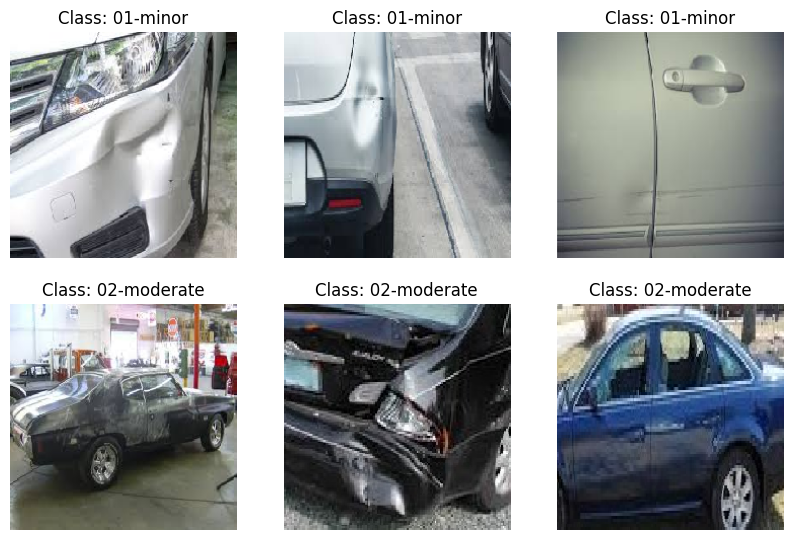

In [ ]:
plot_images_from_dataset2(test_ds)

In [ ]:
from tensorflow.keras import layers, models, optimizers


# Define the model
model = models.Sequential()

# Convolutional and pooling layers
model.add(Conv2D(32, (3, 3),padding='same', activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3),padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(32, (3, 3),padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten layer to transition from convolutional to fully connected layers
model.add(Flatten())

# Dense (fully connected) layers
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))

# Output layer with softmax activation for multiclass classification
model.add(Dense(3, activation='softmax')) # class > 2 -> softmax | class <= 2 -> sigmoid

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 28, 28, 32)        0

In [ ]:
model.compile(loss = 'categorical_crossentropy', # because target class > 2, if categoricall class==2, we use binary_crossentropy
              optimizer ='adam', # alternatively we can use 'scd'
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 'acc'])


In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', patience=35, verbose =1, mode='min'),
             ModelCheckpoint(filepath='car_severity_model.h5', monitor='val_loss', mode='min', save_best_only=True, save_weight_only=False, verbose = 1)]



In [ ]:
history = model.fit_generator(generator=train_ds,
                              epochs = 80,
                              validation_data=valid_ds,
                              callbacks=callbacks,
                              workers = 4,
                              steps_per_epoch = 1383//32,
                              validation_steps = 248//32)

Epoch 1/80
43/43 [==============================] - ETA: 0s - loss: 1.1024 - precision: 0.4569 - recall: 0.0202 - acc: 0.3508
Epoch 1: val_loss improved from inf to 1.09436, saving model to car_severity_model.h5
43/43 [==============================] - 335s 8s/step - loss: 1.1024 - precision: 0.4569 - recall: 0.0202 - acc: 0.3508 - val_loss: 1.0944 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_acc: 0.4020
Epoch 2/80
43/43 [==============================] - ETA: 0s - loss: 1.0892 - precision: 0.5733 - recall: 0.0161 - acc: 0.3998
Epoch 2: val_loss improved from 1.09436 to 1.03770, saving model to car_severity_model.h5
43/43 [==============================] - 307s 7s/step - loss: 1.0892 - precision: 0.5733 - recall: 0.0161 - acc: 0.3998 - val_loss: 1.0377 - val_precision: 1.0000 - val_recall: 0.0050 - val_acc: 0.4839
Epoch 3/80
43/43 [==============================] - ETA: 0s - loss: 1.0312 - precision: 0.6171 - recall: 0.1246 - acc: 0.4662
Epoch 3: val_loss improved from 1.

Accuracy & Loss Graphs

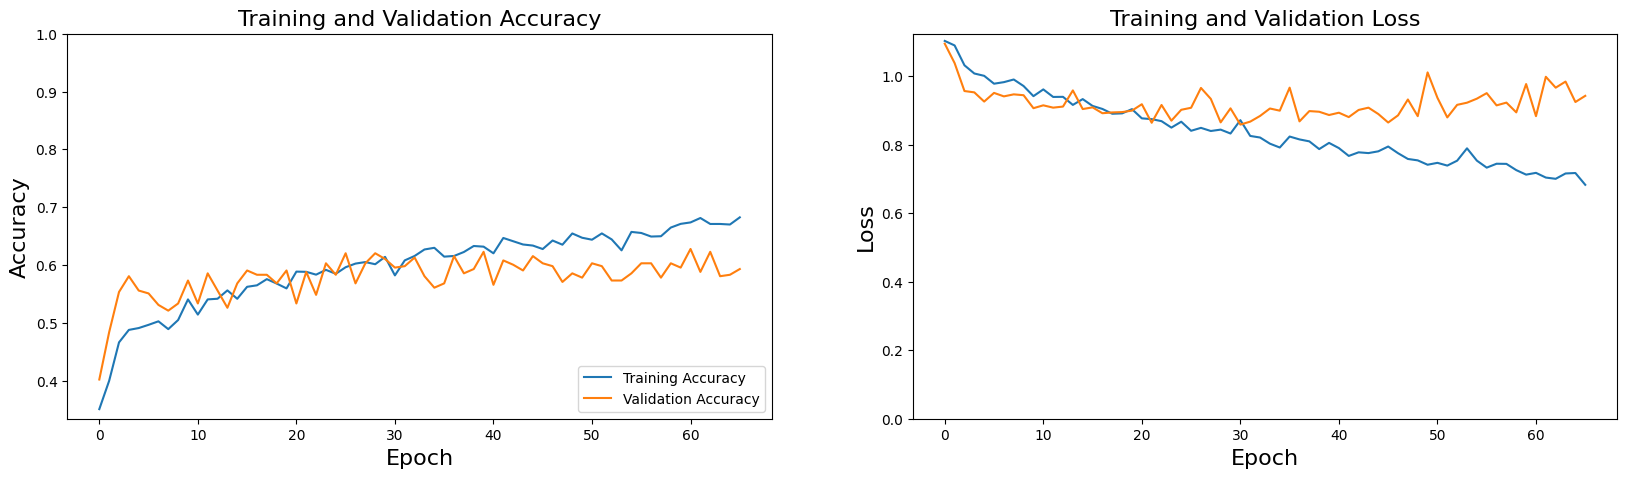

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(history.history['acc'],label='Training Accuracy')
plt.plot(history.history['val_acc'],label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy',fontsize=16)


plt.subplot(1,2,2)
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.ylim([0, max(plt.ylim())])
plt.title('Training and Validation Loss',fontsize=16)
plt.show()

Evaluation

In [ ]:
import tensorflow as tf

# Load the model
model = tf.keras.models.load_model('/content/drive/MyDrive/car_severity_model.h5')

In [ ]:
loss, precision, recall, acc = model.evaluate(test_ds, batch_size = 32)

4/4 [==============================] - 82s 26s/step - loss: 0.8259 - precision: 0.6975 - recall: 0.4556 - acc: 0.5887


In [ ]:
print('\nTest accuracy: %.1f%%' % (100.0 * acc))
print('\nTest loss: %.1f%%' % (100.0 * loss))
print('\nTest precision: %.1f%%' % (100.0 * precision))
print('\nTest recall: %.1f%%' % (100.0 * recall))


Test accuracy: 58.9%

Test loss: 82.6%

Test precision: 69.8%

Test recall: 45.6%


In [ ]:
target_names = list(cl.keys())

In [ ]:
y_pred = np.argmax(model.predict(test_ds), axis=1)
y_true = test_ds.classes
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=cl.keys()))
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:\n", conf_matrix)

4/4 [==============================] - 11s 3s/step
Classification Report:
               precision    recall  f1-score   support

    01-minor       0.83      0.60      0.70        82
 02-moderate       0.36      0.21      0.27        75
   03-severe       0.56      0.89      0.69        91

    accuracy                           0.59       248
   macro avg       0.58      0.57      0.55       248
weighted avg       0.59      0.59      0.56       248


Confusion Matrix:
 [[49 20 13]
 [ 8 16 51]
 [ 2  8 81]]


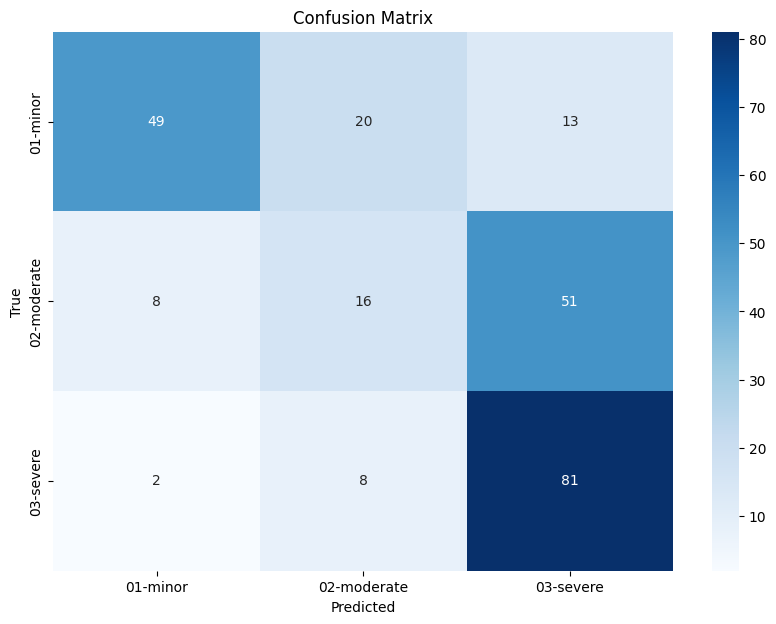

In [ ]:
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
img_height = 224
img_width = 224
target_size = (img_width, img_height)

In [ ]:
key_list = list(cl.keys())
val_list = list(cl.values())
print("KeyList:", key_list)
print("ValueList:", val_list)


KeyList: ['01-minor', '02-moderate', '03-severe']
ValueList: [0, 1, 2]


In [ ]:
def model_testing(path, true_class_label = ""):
  img = image.load_img(path, target_size=(target_size))
  img = image.img_to_array(img, dtype=np.uint8)
  img = np.array(img) / 255.0
  p = model.predict(img.reshape(1,224,224,3))
  predicted_class = np.argmax(p[0])
  predicted_class_item = key_list[predicted_class]
  if true_class_label == "":
    true_class_label = os.path.basename(os.path.dirname(path))

  return img, p, predicted_class_item,true_class_label

In [ ]:
img1,p1,predicted_class_item1,true_class_label1 = model_testing("/content/drive/MyDrive/data3a/validation/03-severe/0006.JPEG")

1/1 [==============================] - 0s 39ms/step


In [ ]:
def visualize_model_test(img, p, predicted_class_item, true_class_label):
  # Visualize the image with the predicted and true class labels
  plt.imshow(img)
  plt.title(f'Predicted class: {predicted_class_item}\nTrue class: {true_class_label}')
  plt.axis('off')
  plt.show()
  # Print the prediction probabilities and the predicted class
  print('Prediction probabilities:', p)
  print('Predicted class:', predicted_class_item)

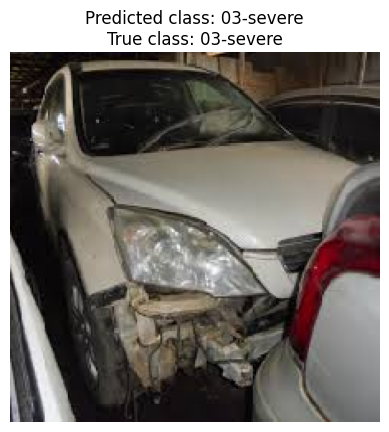

Prediction probabilities: [[0.14870313 0.39473912 0.45655778]]
Predicted class: 03-severe


In [ ]:
visualize_model_test(img1,p1,predicted_class_item1,true_class_label1)

1/1 [==============================] - 0s 39ms/step


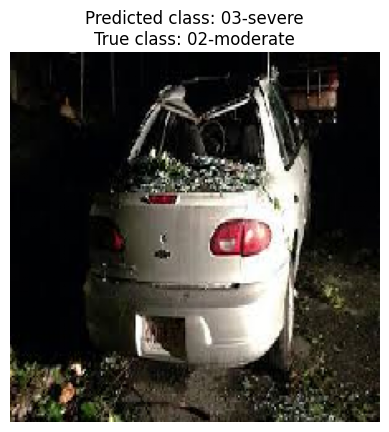

Prediction probabilities: [[0.02890709 0.30857605 0.66251683]]
Predicted class: 03-severe


In [ ]:
img2,p2,predicted_class_item2,true_class_label2 = model_testing("/content/drive/MyDrive/data3a/validation/02-moderate/0008.JPEG")
visualize_model_test(img2,p2,predicted_class_item2,true_class_label2)

1/1 [==============================] - 0s 38ms/step


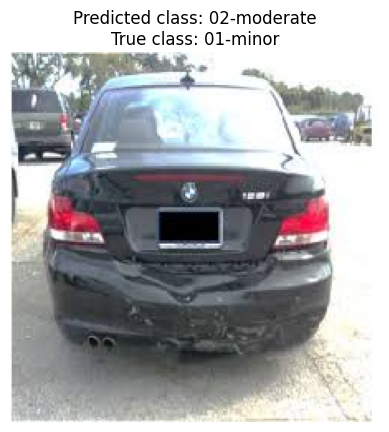

Prediction probabilities: [[0.22596651 0.44493273 0.3291008 ]]
Predicted class: 02-moderate


In [ ]:
img2,p2,predicted_class_item2,true_class_label2 = model_testing("/content/drive/MyDrive/data3a/training/01-minor/0167.JPEG")
visualize_model_test(img2,p2,predicted_class_item2,true_class_label2)

1/1 [==============================] - 0s 162ms/step


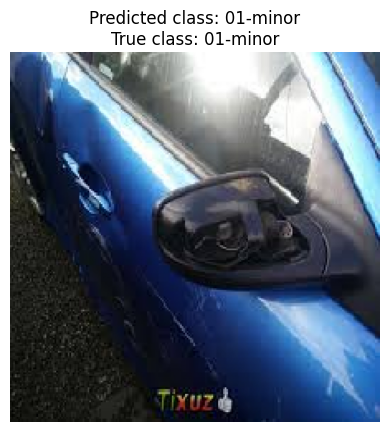

Prediction probabilities: [[0.47941682 0.41827062 0.1023126 ]]
Predicted class: 01-minor


In [ ]:
img3,p3,predicted_class_item3,true_class_label3 = model_testing("/content/drive/MyDrive/data3a/training/01-minor/0225.JPEG")
visualize_model_test(img3,p3,predicted_class_item3,true_class_label3)

1/1 [==============================] - 0s 100ms/step


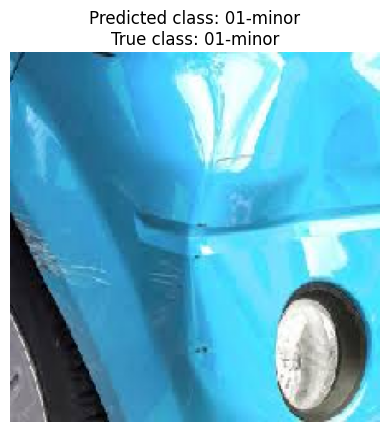

Prediction probabilities: [[9.4704080e-01 5.2524049e-02 4.3508588e-04]]
Predicted class: 01-minor


In [ ]:
img4,p4,predicted_class_item4,true_class_label4 = model_testing("/content/drive/MyDrive/data3a/training/01-minor/images (32).jpeg")
visualize_model_test(img4,p4,predicted_class_item4,true_class_label4)

1/1 [==============================] - 0s 105ms/step


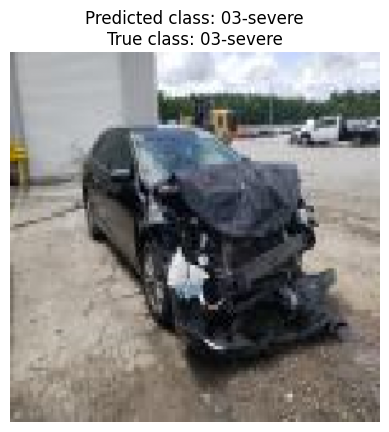

Prediction probabilities: [[0.04676731 0.29909047 0.6541422 ]]
Predicted class: 03-severe


In [ ]:
img5,p5,predicted_class_item5,true_class_label5 = model_testing("/content/drive/MyDrive/data3a/validation/03-severe/c79ee24df16548469dfdb44f154f9887_thb.jpg")
visualize_model_test(img5,p5,predicted_class_item5,true_class_label5)

1/1 [==============================] - 0s 56ms/step


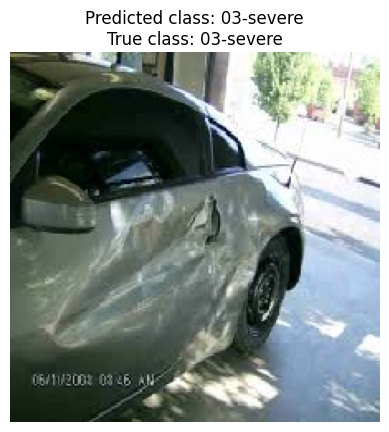

Prediction probabilities: [[0.24385718 0.37417096 0.38197184]]
Predicted class: 03-severe


In [ ]:
img6,p6,predicted_class_item6,true_class_label6 = model_testing("/content/drive/MyDrive/data3a/validation/03-severe/0066.JPEG")
visualize_model_test(img6,p6,predicted_class_item6,true_class_label6 )

1/1 [==============================] - 0s 66ms/step


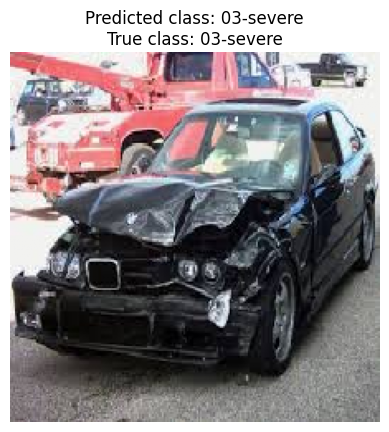

Prediction probabilities: [[0.00831962 0.19164753 0.8000329 ]]
Predicted class: 03-severe


In [ ]:
img7,p7,predicted_class_item7,true_class_label7 = model_testing("/content/drive/MyDrive/data3a/validation/03-severe/0049.JPEG")
visualize_model_test(img7,p7,predicted_class_item7,true_class_label7)

1/1 [==============================] - 0s 40ms/step


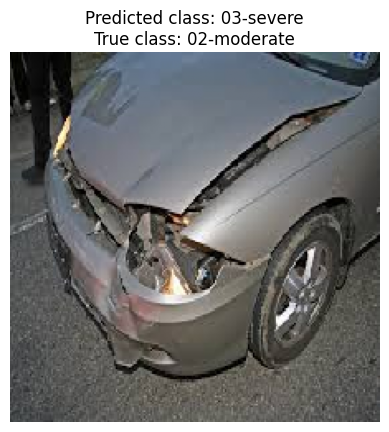

Prediction probabilities: [[0.0519221  0.32617977 0.6218981 ]]
Predicted class: 03-severe


In [ ]:
img8,p8,predicted_class_item8,true_class_label8 = model_testing("/content/drive/MyDrive/data3a/validation/02-moderate/0040.JPEG")
visualize_model_test(img8,p8,predicted_class_item8,true_class_label8)

1/1 [==============================] - 0s 324ms/step


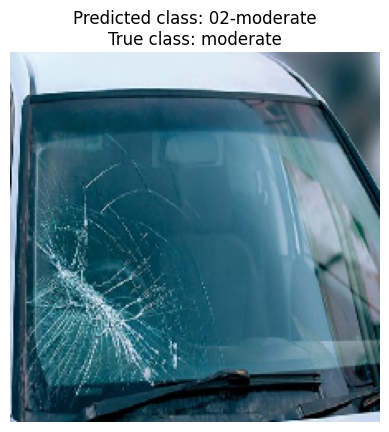

Prediction probabilities: [[0.21757992 0.42220935 0.36021078]]
Predicted class: 02-moderate


In [ ]:
img9,p9,predicted_class_item9,true_class_label9 = model_testing("/content/drive/MyDrive/cars_eren/moderate_5.jpg",true_class_label="moderate")
visualize_model_test(img9,p9,predicted_class_item9,true_class_label9)